### Loading Data

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.io import arff
from pathlib import Path

data_dir = Path().resolve()
file1 = data_dir / "analcatdata_creditscore.arff"
file2 = data_dir / "dataset_54_vehicle.arff"

def load_arff_to_df(file_path):
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    for col in df.select_dtypes([object]).columns:
        df[col] = df[col].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
    return df

df_credit = load_arff_to_df(file1)
df_vehicle = load_arff_to_df(file2)

print("Datasets loaded successfully.")

Datasets loaded successfully.


### Data exploration and preprocessing

(missing values, outliers, scaling, encoding, etc.)

#### Credit Score Dataset Overview
Entries:    100  
Columns:    7  
Response variable: "Application.accepted"  
Missing values: No  
Data types: float, object (binary)

| Column | Type | Observations |
| ----------- | ----------- | ----------- |
| Age | numeric | Range 20-55, mean ~32 |
| Income.per.dependent | numeric | 
| Monthly.credit.card.exp | numeric | Range 0-1898, mean~189 |
| Own.home | categorical | binary(0,1); 64 yes, 36 no |
| Self.employed | categorical | binary(0,1); 95 no, 5 yes |
| Derogatory.reports | categorical | range 0-7, 82 no |
| **Application.accepted** | categorical | binary(0,1); 73 yes, 27 no |

Considerations for Pre-Processing: 
- The categorical values are currently stored as String ('0', '1')
- The numeric values should be scaled. 
- Self.employed, Derogatory.reports and Application.accepted are skewed
- Monthly.credit.card.exp already shows outliers (max 1898 vs mean 189)
- There are no missing values 

In [65]:
# --- Credit Score Dataset Overview ---

display(df_credit.info())       # 100 entries, 7 columns; dtypes: float64(3), object(4)
print(df_credit.isnull().sum())
display(df_credit.head())
print(df_credit.describe(include='all').transpose())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      100 non-null    float64
 1   Income.per.dependent     100 non-null    float64
 2   Monthly.credit.card.exp  100 non-null    float64
 3   Own.home                 100 non-null    object 
 4   Self.employed            100 non-null    object 
 5   Derogatory.reports       100 non-null    object 
 6   Application.accepted     100 non-null    object 
dtypes: float64(3), object(4)
memory usage: 5.6+ KB


None

Age                        0
Income.per.dependent       0
Monthly.credit.card.exp    0
Own.home                   0
Self.employed              0
Derogatory.reports         0
Application.accepted       0
dtype: int64


,Age,Income.per.dependent,Monthly.credit.card.exp,Own.home,Self.employed,Derogatory.reports,Application.accepted
0,38.0,4.52,124.98,1,0,0,1
1,33.0,2.42,9.85,0,0,0,1
2,34.0,4.50,15.00,1,0,0,1
3,31.0,2.54,137.87,0,0,0,1
4,32.0,9.79,546.50,1,0,0,1


                         count unique  top freq      mean         std   min  \
Age                      100.0    NaN  NaN  NaN     32.08    7.828567  20.0   
Income.per.dependent     100.0    NaN  NaN  NaN    3.3693    1.629013   1.5   
Monthly.credit.card.exp  100.0    NaN  NaN  NaN  189.0231  294.244598   0.0   
Own.home                   100      2    0   64       NaN         NaN   NaN   
Self.employed              100      2    0   95       NaN         NaN   NaN   
Derogatory.reports         100      6    0   82       NaN         NaN   NaN   
Application.accepted       100      2    1   73       NaN         NaN   NaN   

                           25%     50%      75%      max  
Age                       26.0    31.0     37.0     55.0  
Income.per.dependent     2.365     3.0     3.97     10.0  
Monthly.credit.card.exp    0.0  81.295  252.805  1898.03  
Own.home                   NaN     NaN      NaN      NaN  
Self.employed              NaN     NaN      NaN      NaN  
Derogatory.re

In [66]:
# Convert strings to integers 
string_cols = ["Own.home", "Self.employed", "Application.accepted", "Derogatory.reports"]

for col in string_cols:
    df_credit[col] = pd.to_numeric(df_credit[col], errors="coerce").astype("Int64")

# # Verify conversion
# for col in string_cols:
#     print(f"{col}: {df_credit[col].unique()}")


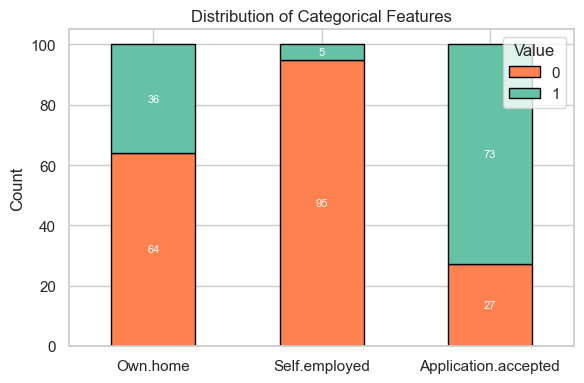

In [67]:
# ---- Visualization of categorical features distribution ---
cols_to_plot = ["Own.home", "Self.employed", "Application.accepted"]
colors = {0: "#ff814f", 1: "#66c2a5"}  

counts = {col: df_credit[col].value_counts().sort_index() for col in cols_to_plot}
counts_df = pd.DataFrame(counts).T.fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(6, 4))
counts_df.plot(
    kind="bar",
    stacked=True,
    color=colors,
    ax=ax,
    edgecolor="black"
)

ax.set_ylabel("Count")
ax.set_xlabel("")
ax.set_title("Distribution of Categorical Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")       # rotate x-axis labels
ax.legend(title="Value", loc="upper right")

for container in ax.containers:                                         # count labels
    ax.bar_label(container, label_type='center', color="white", fontsize=8)

plt.tight_layout()
plt.show()


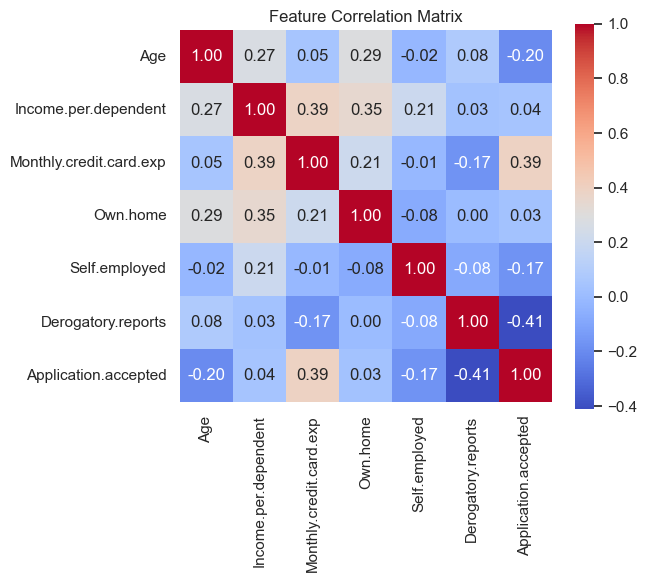

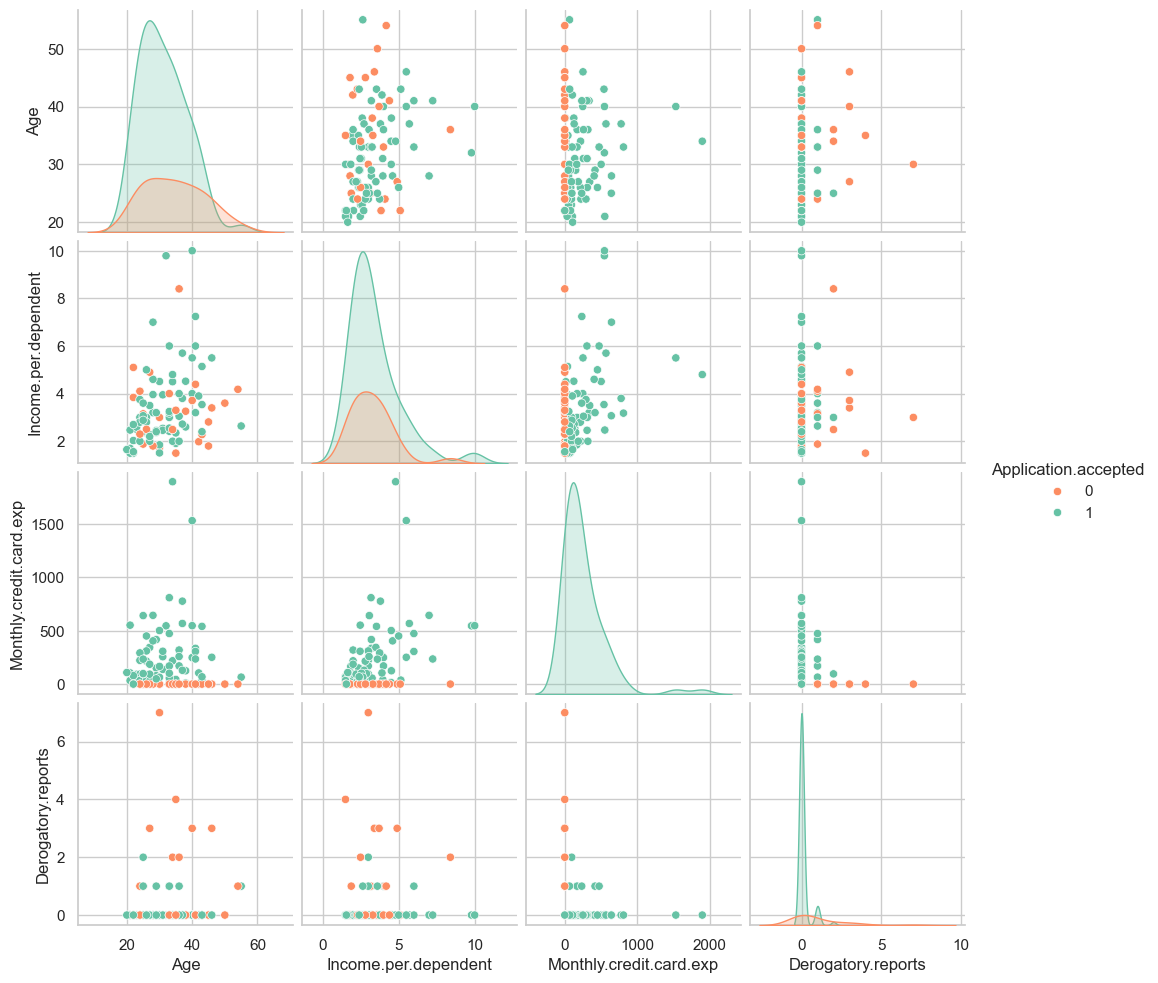

In [68]:
# --- Correlation Heatmap ---
numeric_df = df_credit.select_dtypes(include=[np.number])

plt.figure(figsize=(6, 5))
corr = numeric_df.corr()
sns.heatmap(
    corr, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    square=True)
plt.title("Feature Correlation Matrix")
plt.show()

# --- Pairplot ---
pairplot_features = ["Age", "Income.per.dependent", "Monthly.credit.card.exp", "Derogatory.reports"]
sns.pairplot(
    df_credit[pairplot_features + ["Application.accepted"]], 
    hue="Application.accepted", 
    diag_kind="kde", 
    palette={1: "#66c2a5", 0: "#fc8d62"} )
plt.show()



#### Vehicle Dataset Overview
Entries: 846  
Columns: 19  
Response variable: "class"  
Missing values: No  
Data types: float, object (String)

In [69]:
# --- Vehicle Dataset Overview ---
display(df_vehicle.info())   # 846 entries, 19 columns; dtypes: float64(18), object(1)
print(df_vehicle.isnull().sum())
display(df_vehicle.head())   
(df_vehicle.describe(include='all').transpose())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COMPACTNESS                846 non-null    float64
 1   CIRCULARITY                846 non-null    float64
 2   DISTANCE_CIRCULARITY       846 non-null    float64
 3   RADIUS_RATIO               846 non-null    float64
 4   PR.AXIS_ASPECT_RATIO       846 non-null    float64
 5   MAX.LENGTH_ASPECT_RATIO    846 non-null    float64
 6   SCATTER_RATIO              846 non-null    float64
 7   ELONGATEDNESS              846 non-null    float64
 8   PR.AXIS_RECTANGULARITY     846 non-null    float64
 9   MAX.LENGTH_RECTANGULARITY  846 non-null    float64
 10  SCALED_VARIANCE_MAJOR      846 non-null    float64
 11  SCALED_VARIANCE_MINOR      846 non-null    float64
 12  SCALED_RADIUS_OF_GYRATION  846 non-null    float64
 13  SKEWNESS_ABOUT_MAJOR       846 non-null    float64

None

COMPACTNESS                  0
CIRCULARITY                  0
DISTANCE_CIRCULARITY         0
RADIUS_RATIO                 0
PR.AXIS_ASPECT_RATIO         0
MAX.LENGTH_ASPECT_RATIO      0
SCATTER_RATIO                0
ELONGATEDNESS                0
PR.AXIS_RECTANGULARITY       0
MAX.LENGTH_RECTANGULARITY    0
SCALED_VARIANCE_MAJOR        0
SCALED_VARIANCE_MINOR        0
SCALED_RADIUS_OF_GYRATION    0
SKEWNESS_ABOUT_MAJOR         0
SKEWNESS_ABOUT_MINOR         0
KURTOSIS_ABOUT_MAJOR         0
KURTOSIS_ABOUT_MINOR         0
HOLLOWS_RATIO                0
Class                        0
dtype: int64


,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95.0,48.0,83.0,178.0,72.0,10.0,162.0,42.0,20.0,159.0,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197.0,van
1,91.0,41.0,84.0,141.0,57.0,9.0,149.0,45.0,19.0,143.0,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199.0,van
2,104.0,50.0,106.0,209.0,66.0,10.0,207.0,32.0,23.0,158.0,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196.0,saab
3,93.0,41.0,82.0,159.0,63.0,9.0,144.0,46.0,19.0,143.0,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207.0,van
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,bus


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
COMPACTNESS,846.0,NaN,NaN,NaN,93.678487,8.234474,73.0,87.0,93.0,100.0,119.0
CIRCULARITY,846.0,NaN,NaN,NaN,44.861702,6.169866,33.0,40.0,44.0,49.0,59.0
DISTANCE_CIRCULARITY,846.0,NaN,NaN,NaN,82.088652,15.771533,40.0,70.0,80.0,98.0,112.0
RADIUS_RATIO,846.0,NaN,NaN,NaN,168.940898,33.472183,104.0,141.0,167.0,195.0,333.0
PR.AXIS_ASPECT_RATIO,846.0,NaN,NaN,NaN,61.693853,7.888251,47.0,57.0,61.0,65.0,138.0
MAX.LENGTH_ASPECT_RATIO,846.0,NaN,NaN,NaN,8.567376,4.601217,2.0,7.0,8.0,10.0,55.0
SCATTER_RATIO,846.0,NaN,NaN,NaN,168.839243,33.244978,112.0,146.25,157.0,198.0,265.0
ELONGATEDNESS,846.0,NaN,NaN,NaN,40.933806,7.81156,26.0,33.0,43.0,46.0,61.0
PR.AXIS_RECTANGULARITY,846.0,NaN,NaN,NaN,20.582742,2.592138,17.0,19.0,20.0,23.0,29.0
MAX.LENGTH_RECTANGULARITY,846.0,NaN,NaN,NaN,147.998818,14.515652,118.0,137.0,146.0,159.0,188.0


### Classification

Carry out the classification:
- Run classifiers, and Experiment with:
    - Different classifiers and your datasets
    - Different parameter settings (= several results per classifier per dataset, not only
random/best)

In [70]:
# Model 0: Logistic Regression model with all predictors and no scaling/data cleaning beforehand
# Later to be used as comparison

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df_credit.drop(columns=["Application.accepted"])        # predictors
y = df_credit["Application.accepted"]                       # response

# Split data: 2/3 train, 1/3 test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=1/3,       
    random_state=42,     # seed
    stratify=y           
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Fit model
model_logreg = LogisticRegression(max_iter=1000, random_state=42)
model_logreg.fit(X_train, y_train)

# Predict
y_pred = model_logreg.predict(X_test)
y_prob = model_logreg.predict_proba(X_test)[:, 1]  # probability of class 1

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))


Training set: 66 samples
Test set: 34 samples
Accuracy: 1.0

Confusion Matrix:
[[ 9  0]
 [ 0 25]]

Classification Report:
              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000         9
         1.0      1.000     1.000     1.000        25

    accuracy                          1.000        34
   macro avg      1.000     1.000     1.000        34
weighted avg      1.000     1.000     1.000        34



##### Model 0 report: 

The model has 100% accuracy which means there have to be issues with the data. This is also visible in the confusion matrix: The model only predicted true negatives (9) and true positives (25), but neither false negatives nor false positives.

The likely reason is that small size of the data set. Some variables (like derogatory.reports) have such a strong correlation with the response variable that they are essentially deterministic predictors - the model only needs to know these variables to make a correct prediction about whether an application was accepted or not.

Looking at the mean values of accepted and rejected applications we can see that the monthly.credit.card.exp for rejected applications is *0* and the derogatory reports vary wiledly (0.1 vs 1+).

Looking at the two suspicious variables further it becomes clear that the monthly.credit.card.exp is a very strong indicator for whether the application gets accepted or not - *all* 27 rejected applications have a value of 0. 

In [71]:
df_credit.groupby("Application.accepted").mean()

,Age,Income.per.dependent,Monthly.credit.card.exp,Own.home,Self.employed,Derogatory.reports
Application.accepted,,,,,,
0,34.592593,3.255556,0.000000,0.333333,0.111111,1.037037
1,31.150685,3.411370,258.935753,0.369863,0.027397,0.109589


In [72]:
df_credit.groupby("Application.accepted")[["Monthly.credit.card.exp", "Derogatory.reports"]].describe()

Monthly.credit.card.exp                               \
                                       count        mean         std  min   
Application.accepted                                                        
0                                       27.0    0.000000    0.000000  0.0   
1                                       73.0  258.935753  317.321643  0.0   

                                                     Derogatory.reports  \
                        25%     50%     75%      max              count   
Application.accepted                                                      
0                      0.00    0.00    0.00     0.00               27.0   
1                     65.25  150.79  319.49  1898.03               73.0   

                                                                   
                          mean       std  min  25%  50%  75%  max  
Application.accepted                                               
0                     1.037037  1.697996  0.0  0.0  0.0  1.5  7.0  
1                     0.109589  0.355967  0.0  0.0  0.0  0.0  2.0

### Performance

Evaluate and analyse the performance (primarily effectiveness, but also provide basic
details on efficiency):
- Choose suitable, multiple performance measures
- Make valid comparisons (among the classifiers, across your datasets, parameters,
preprocessing effects...)
- (How) can you improve the results?
- Can you identify any patterns/trends?
    - Which methods work well and which did not, is there e.g. one method
outperforming the others on all datasets?
    - How do the results change when preprocessing strategies change? How sensitive
is an algorithm to parameter settings?
    - Are there differences across the datasets? Design your experiments so that you
can investigate the influence of single parameters

Age                        float64
Income.per.dependent       float64
Monthly.credit.card.exp    float64
Own.home                     Int64
Self.employed                Int64
Derogatory.reports           Int64
dtype: object

### Holdout vs Cross-Validation

- Pay attention to your splits and settings
Are there differences? Why? In which metrics? What could have caused it?
- Compare/document changes in runtime behaviour with the changing e.g. dataset size

### Summary